In [193]:
!pip install opencv-python-headless

In [194]:
import os
import cv2 # OpenCV
import numpy as np
import tensorflow as tf
from ultralytics import YOLO
import matplotlib.pyplot as plt

# ---------------------------------
# 1. КОНФІГУРАЦІЯ
# ---------------------------------
print("--- Етап 1: Завантаження моделей ---")

# --- ВКАЖІТЬ ПРАВИЛЬНІ ШЛЯХИ ДО ВАШИХ МОДЕЛЕЙ ---

# Шлях до Детектора (YOLO)
# Знайдіть його у папці /runs/detect/train.../
YOLO_MODEL_PATH = './runs/detect/train9/weights/best.pt'

# Шлях до Класифікатора (Keras)
CLASSIFIER_MODEL_PATH = "../models/digit_classifier_best.keras"

# --- ВКАЖІТЬ ШЛЯХ ДО ЗОБРАЖЕННЯ ДЛЯ ТЕСТУ ---
# Візьміть будь-яке з папки ../data_number/valid/images/

# Параметри класифікатора (мають збігатися з тими, на яких вчили)
CLASSIFIER_IMG_SIZE = (64, 64)
CLASS_NAMES = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '11']
try:
    # Завантажуємо Детектор
    detector_model = YOLO(YOLO_MODEL_PATH)
    print(f"Детектор (YOLO) завантажено з: {YOLO_MODEL_PATH}")

    # Завантажуємо Класифікатор
    classifier_model = tf.keras.models.load_model(CLASSIFIER_MODEL_PATH)
    print(f"Класифікатор (Keras) завантажено з: {CLASSIFIER_MODEL_PATH}")

except Exception as e:
    print(f"Помилка завантаження моделі: {e}")
    print("Перевірте, чи правильні шляхи у КОНФІГУРАЦІЇ.")
# ---------------------------------
# 2. ЗАВАНТАЖЕННЯ МОДЕЛЕЙ
# ---------------------------------
# [ ... ВЕСЬ КОД ДО ЦЬОГО ЗАЛИШАЄТЬСЯ БЕЗ ЗМІН ... ]

# ---------------------------------
# 2. НОВА ФУНКЦІЯ ПЕРЕДОБРОБКИ (v3 - Ваша ідея)
# ---------------------------------



--- Етап 1: Завантаження моделей ---
Детектор (YOLO) завантажено з: ./runs/detect/train9/weights/best.pt
Класифікатор (Keras) завантажено з: ../models/digit_classifier_best.keras


In [195]:
def preprocess_for_classifier(image_crop_gray, target_size=(64, 64)):
    """
    Правильно готує зображення:
    1. Вписує (Letterbox) у (64, 64) зі збереженням пропорцій.
    """
    h, w = image_crop_gray.shape[:2]
    if h == 0 or w == 0:
        return np.zeros((1, target_size[0], target_size[1], 1), dtype=np.float32)

    scale = min(target_size[0] / h, target_size[1] / w)
    new_w, new_h = int(w * scale), int(h * scale)
    if new_h <= 0 or new_w <= 0: new_h, new_w = 1, 1

    resized_img = cv2.resize(image_crop_gray, (new_w, new_h), interpolation=cv2.INTER_AREA)

    delta_w, delta_h = target_size[1] - new_w, target_size[0] - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    final_canvas = cv2.copyMakeBorder(resized_img, top, bottom, left, right,
                                     cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # НЕМАЄ ІНВЕРСІЇ (bitwise_not)
    final_image = final_canvas

    final_image_float = final_image.astype(np.float32)
    input_tensor = np.expand_dims(final_image_float, axis=0)
    input_tensor = np.expand_dims(input_tensor, axis=-1)

    return input_tensor




In [196]:

print("\n--- Етап 2: Обробка зображення ---")

# ---------------------------------
# 3. ЕТАП ДЕТЕКЦІЇ (YOLO)
# ---------------------------------

# Завантажуємо тестове зображення
TEST_IMAGE_PATH = './learning/data_number/valid/images/img_00020.png'
original_image = cv2.imread(TEST_IMAGE_PATH)
if original_image is None:
    print(f"Помилка: не вдалося завантажити зображення {TEST_IMAGE_PATH}")
else:
    print(f"Тестове зображення завантажено: {TEST_IMAGE_PATH}")
# Подаємо зображення на Детектор
# conf=0.5 означає, що ми ігноруємо знахідки з упевненістю < 50%
results = detector_model.predict(original_image, conf=0.5)
detections = results[0].boxes.data.cpu().numpy() # [x1, y1, x2, y2, conf, class_id]
print(f"Знайдено {len(detections)} об'єктів (цифр).")



--- Етап 2: Обробка зображення ---
Тестове зображення завантажено: ./learning/data_number/valid/images/img_00020.png

0: 640x640 1 0, 2 4s, 1 5, 1 6, 4.8ms
Speed: 1.8ms preprocess, 4.8ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)
Знайдено 5 об'єктів (цифр).


In [197]:
# ---------------------------------
# 4. ЕТАП КЛАСИФІКАЦІЇ (KERAS)
# ---------------------------------
recognized_digits = []
annotated_image = original_image.copy()

for detection in detections:
    x1, y1, x2, y2 = map(int, detection[:4])

    # 1. Вирізаємо цифру (з невеликими полями)
    padding = 0 # Зменшив padding, щоб він не захоплював сусідні цифри
    cropped_digit_bgr = original_image[max(0, y1-padding):min(original_image.shape[0], y2+padding),
                                       max(0, x1-padding):min(original_image.shape[1], x2+padding)]

    if cropped_digit_bgr.size == 0:
        continue

    # 2. Передобробка для Класифікатора (конвертація в сірий)
    cropped_digit_gray = cv2.cvtColor(cropped_digit_bgr, cv2.COLOR_BGR2GRAY)

    # 3. ВИКОРИСТОВУЄМО НОВУ ФУНКЦІЮ (з letterbox)
    input_tensor = preprocess_for_classifier(cropped_digit_gray, CLASSIFIER_IMG_SIZE)

    # 4. Прогноз Класифікатора
    prediction = classifier_model.predict(input_tensor, verbose=0)
    predicted_class_id = np.argmax(prediction)
    predicted_class_name = CLASS_NAMES[predicted_class_id]
    confidence = np.max(prediction)

    # 5. Фільтруємо "сміття"
    if predicted_class_name == 'GARBAGE':
        print(f"  > Знайдено об'єкт (ймовірно, сміття), ігноруємо.")
        cv2.rectangle(annotated_image, (x1, y1), (x2, y2), (0, 255, 255), 2)
        continue

    # 6. Зберігаємо результат
    print(f"  > Знайдено '{predicted_class_name}' (впевненість: {confidence*100:.1f}%) на позиції X={x1}")
    recognized_digits.append((x1, predicted_class_name))

    # Малюємо рамку і підпис
    cv2.rectangle(annotated_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(annotated_image, predicted_class_name, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

2025-11-04 18:18:57.208731: I external/local_xla/xla/service/service.cc:163] XLA service 0x770748011b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-04 18:18:57.208894: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-11-04 18:18:57.223620: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762280337.915563    2476 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  > Знайдено '5' (впевненість: 100.0%) на позиції X=212
  > Знайдено '2' (впевненість: 34.7%) на позиції X=244
  > Знайдено '0' (впевненість: 99.9%) на позиції X=306
  > Знайдено '2' (впевненість: 97.8%) на позиції X=276
  > Знайдено '5' (впевненість: 100.0%) на позиції X=341


In [198]:
# ---------------------------------
# 5. ЕТАП ЗБІРКИ
# ---------------------------------

# Сортуємо знайдені цифри за їхньою X-координатою (зліва направо)
recognized_digits.sort(key=lambda d: d[0])

# Збираємо фінальне число
final_number_str = "".join([digit for (x, digit) in recognized_digits])

print("\n--- ✅ ФІНАЛЬНИЙ РЕЗУЛЬТАТ ---")
print(f"Розпізнане число: {final_number_str}")


--- ✅ ФІНАЛЬНИЙ РЕЗУЛЬТАТ ---
Розпізнане число: 52205


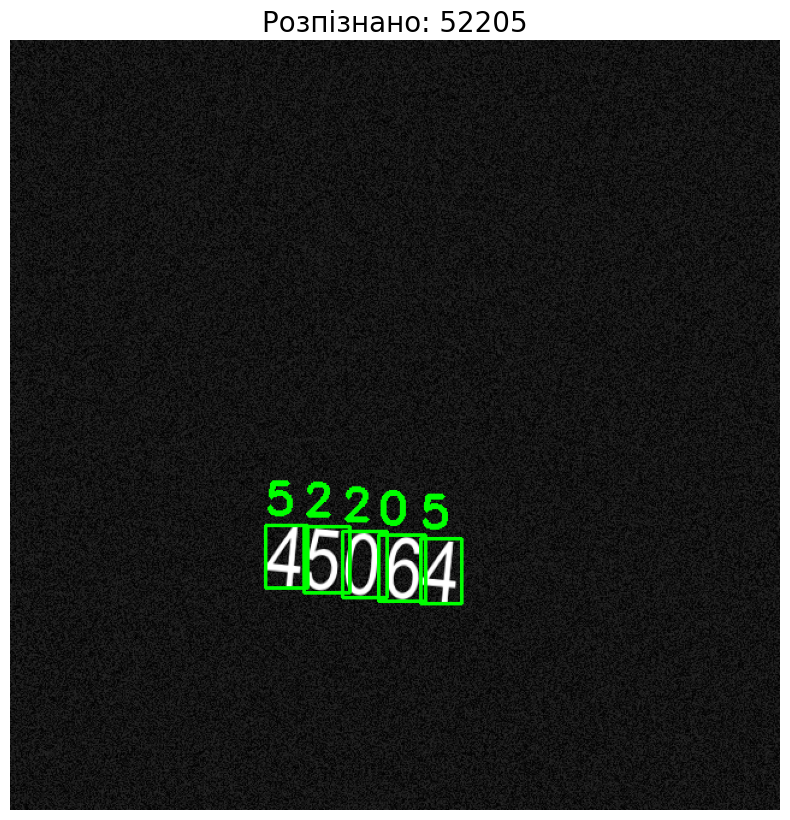

In [199]:


# ---------------------------------
# 6. ВІЗУАЛІЗАЦІЯ
# ---------------------------------

# Відображаємо зображення з рамками
# (конвертуємо BGR в RGB для Matplotlib)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title(f"Розпізнано: {final_number_str}", fontsize=20)
plt.axis('off')
plt.show()